In [1]:
import pandas as pd
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

2024-07-31 08:46:50.708439: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 08:46:50.708537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 08:46:50.858356: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
filedr = '/kaggle/input/car-color-dataset'

In [3]:
import os
files = os.listdir(filedr)
files

['orange',
 'tan',
 'yellow',
 'purple',
 'silver',
 'grey',
 'pink',
 'black',
 'blue',
 'white',
 'green',
 'beige',
 'red',
 'brown']

In [4]:
images = []
labels = []
color_classes = os.listdir(filedr)
for color_class in color_classes:
    color_path = os.path.join(filedr, color_class)
    for filename in os.listdir(color_path):
        img = Image.open(os.path.join(color_path, filename))
        if img is not None:
            img = img.resize((128, 128))  # Resize if necessary
            img_array = np.array(img)  # Convert image to numpy array
            images.append(img_array)
            labels.append(color_class)

In [5]:
shapes = [img.shape for img in images]
unique_shapes = set(shapes)
print("Unique shapes found in images:", unique_shapes)

Unique shapes found in images: {(128, 128, 4), (128, 128), (128, 128, 3)}


In [6]:
indices_to_remove = [i for i, img in enumerate(images) 
                     if (img.shape == (128, 128))]

# Remove images and corresponding labels
images_filtered = [img for i, img in enumerate(images) if i not in indices_to_remove]
labels_filtered = [label for i, label in enumerate(labels) if i not in indices_to_remove]

In [7]:
len(images_filtered)

10525

In [8]:
len(labels_filtered)

10525

In [9]:
len(np.unique(labels_filtered))

14

In [10]:
colors_count = dict(Counter(labels_filtered))
colors_count

{'orange': 762,
 'tan': 620,
 'yellow': 824,
 'purple': 765,
 'silver': 659,
 'grey': 645,
 'pink': 689,
 'black': 691,
 'blue': 1060,
 'white': 687,
 'green': 804,
 'beige': 603,
 'red': 909,
 'brown': 807}

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


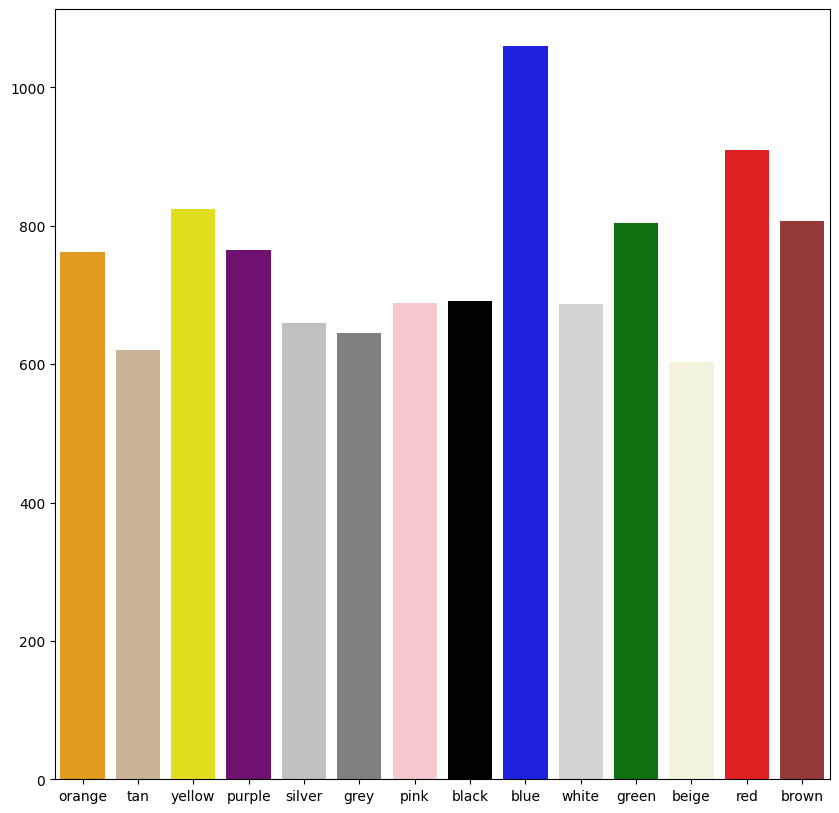

In [11]:
plt.figure(figsize=(10,10))
sns.barplot(x=list(colors_count.keys()), y=list(colors_count.values()), palette={key: key if key not in ['white'] else 'lightgrey' for key in list(colors_count.keys())})
plt.show()

In [12]:
def display_random_images(images, colors,num_images=3):
    num_cols = 7  # Number of columns for subplots (adjust as needed)
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate number of rows needed
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

    for i in range(num_images):
        row = i//num_cols
        col = i % num_cols
        # Select a random index
        random_index = random.randint(0, len(images) - 1)
        image = images[random_index]
        color = colors[random_index]

        # Load and display the image
        axs[row, col].imshow(image)
        axs[row, col].set_title(f'color: {color}')
        axs[row, col].axis('off')
        
    for i in range(num_images, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axs[row, col].axis('off')
        
    plt.tight_layout()
    plt.show()

In [13]:
images_filtered[0].shape

(128, 128, 3)

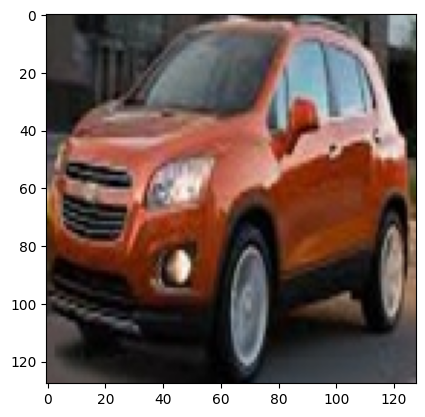

In [14]:
plt.imshow(images_filtered[3])

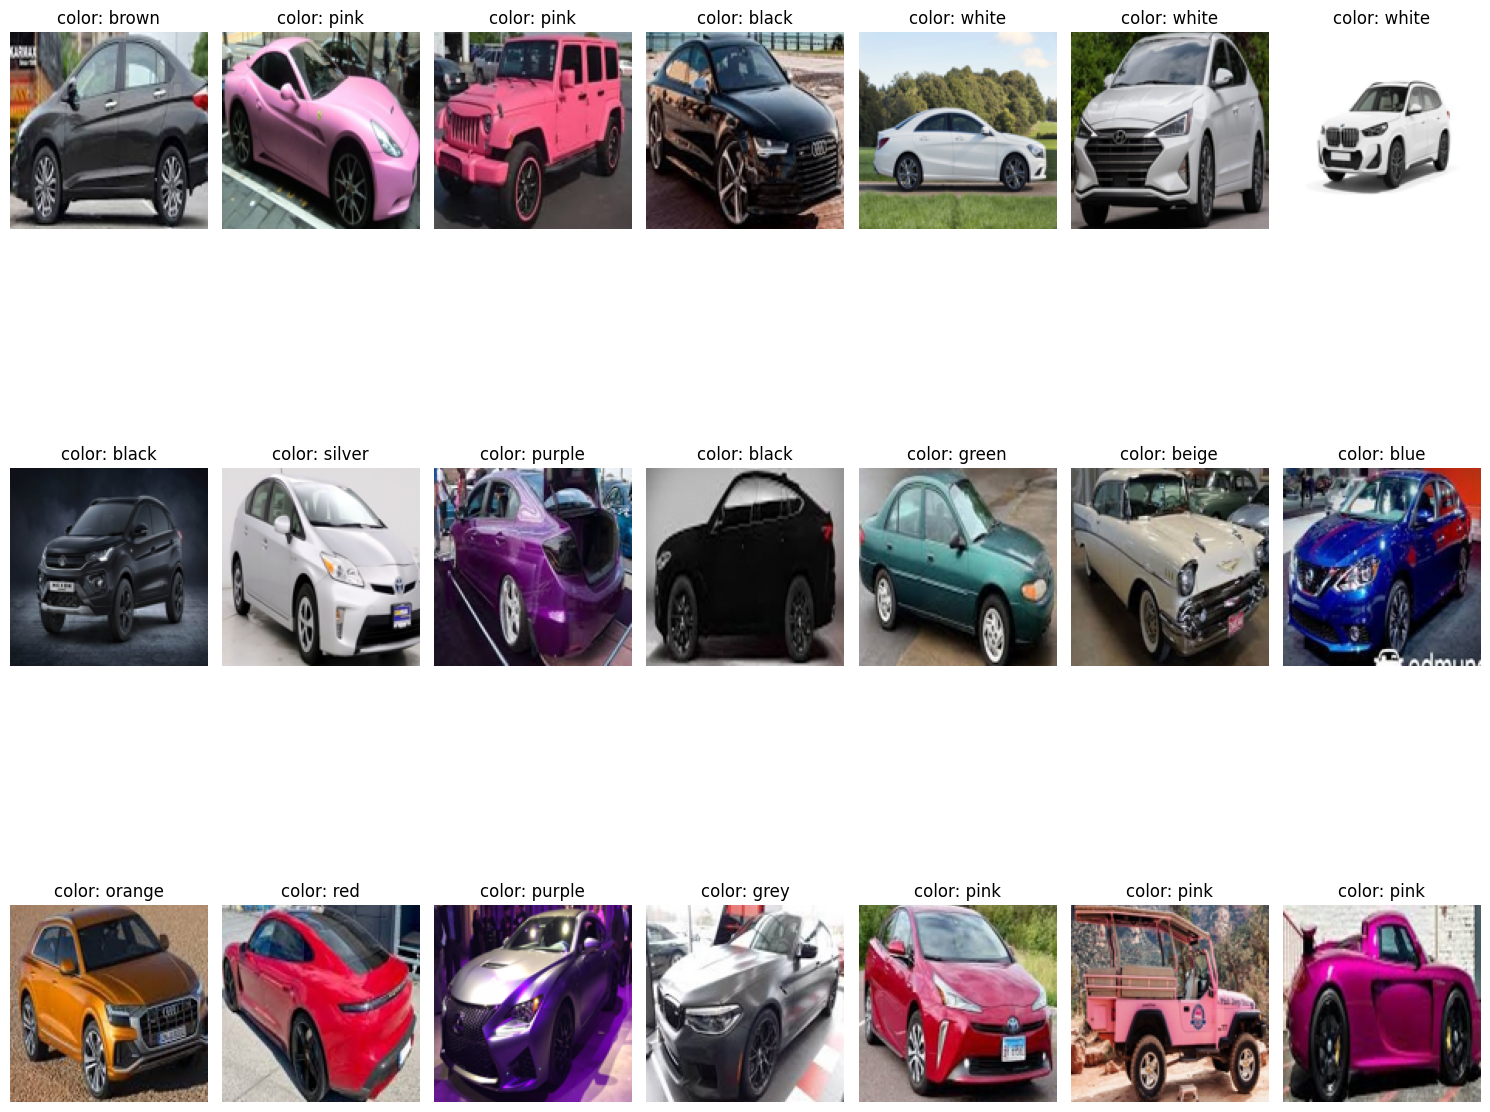

In [15]:
display_random_images(images_filtered,labels_filtered, 21)

In [16]:
datagen = ImageDataGenerator(
    rotation_range=30,            
    width_shift_range=0.2,        
    height_shift_range=0.2,       
    horizontal_flip=True,     
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

# Convert images to NumPy arrays after augmentation
images_augmented = []
for image in images_filtered:
    augmented_image = datagen.random_transform(image)
    images_augmented.append(augmented_image)

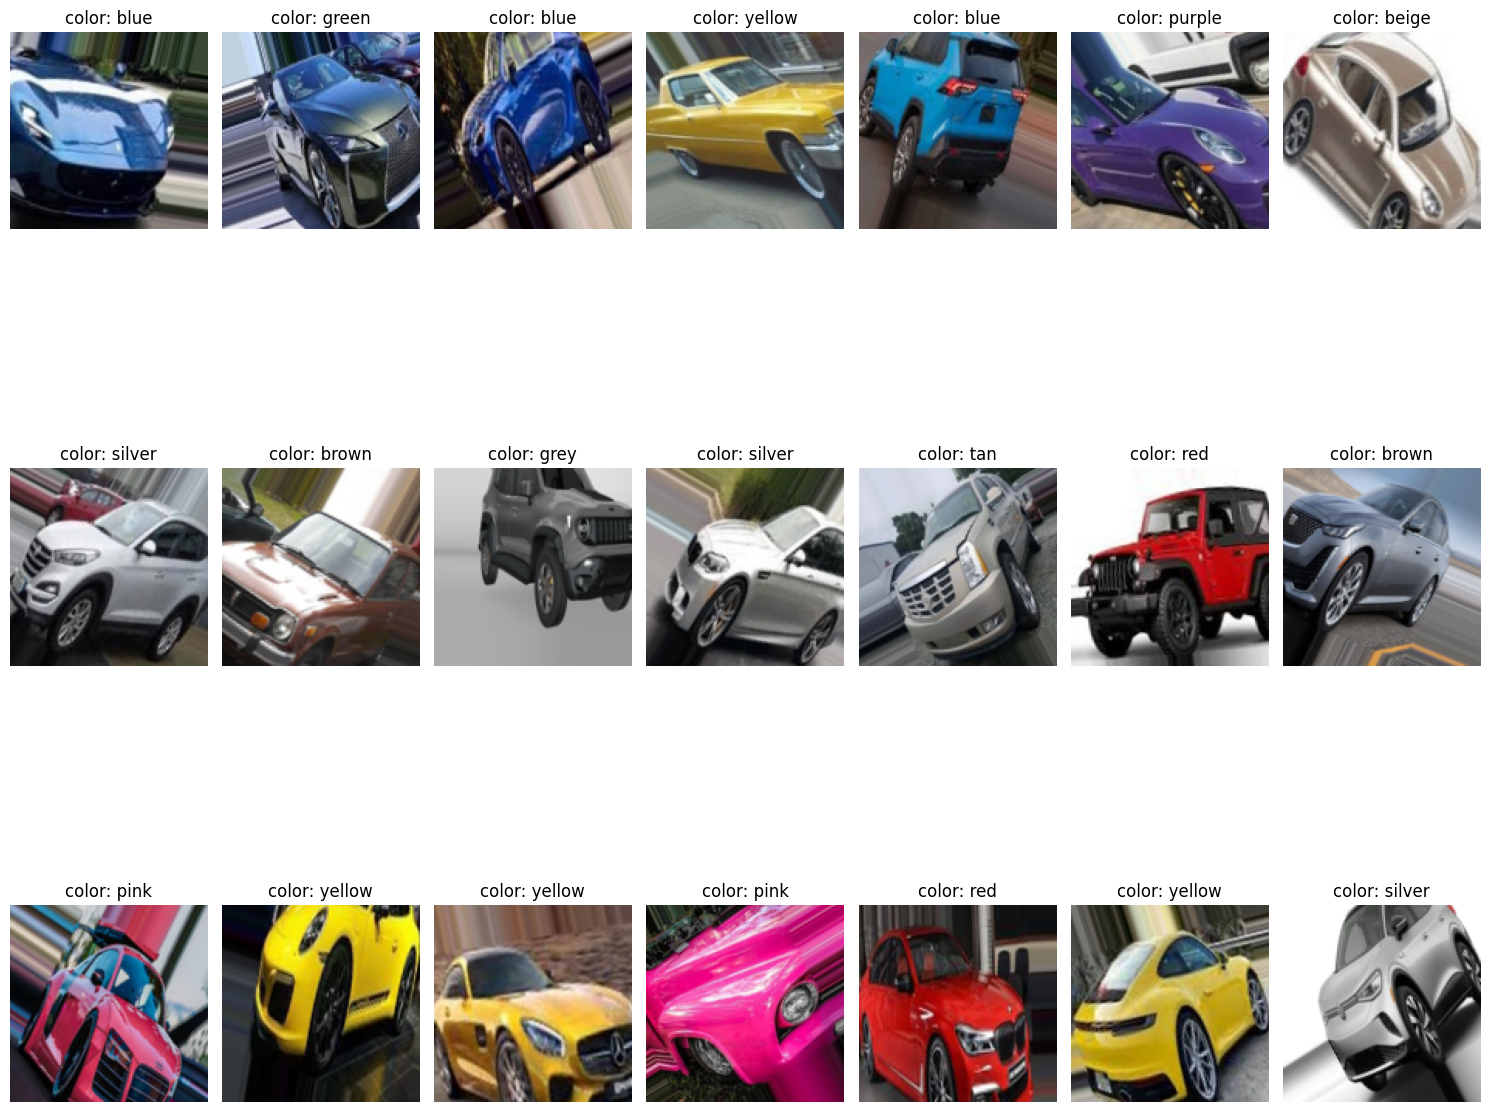

In [17]:
display_random_images(images_augmented,labels_filtered, 21)

In [18]:
label_encoder = LabelEncoder()

In [19]:
numerical_labels = label_encoder.fit_transform(labels_filtered)
numerical_labels

array([6, 6, 6, ..., 3, 3, 3])

In [20]:
len(numerical_labels)

10525

In [21]:
labelled = []
for label, numerical_label in zip(labels_filtered, numerical_labels):
    pair=(label,numerical_label)
    if pair not in labelled:
        labelled.append(pair)
labelled = sorted(labelled)
labelled

[('beige', 0),
 ('black', 1),
 ('blue', 2),
 ('brown', 3),
 ('green', 4),
 ('grey', 5),
 ('orange', 6),
 ('pink', 7),
 ('purple', 8),
 ('red', 9),
 ('silver', 10),
 ('tan', 11),
 ('white', 12),
 ('yellow', 13)]

In [22]:
images_filtered[0]

array([[[ 59,  59,  57],
        [ 85,  85,  82],
        [ 89,  86,  85],
        ...,
        [ 38,  36,  38],
        [ 25,  24,  28],
        [ 20,  21,  25]],

       [[ 70,  70,  68],
        [ 85,  84,  82],
        [ 83,  80,  78],
        ...,
        [ 27,  27,  28],
        [ 23,  23,  27],
        [ 23,  26,  29]],

       [[ 74,  74,  72],
        [ 75,  74,  72],
        [ 67,  63,  62],
        ...,
        [ 27,  28,  29],
        [ 19,  23,  26],
        [ 22,  26,  29]],

       ...,

       [[212, 212, 200],
        [212, 212, 200],
        [213, 213, 201],
        ...,
        [185, 187, 174],
        [187, 189, 176],
        [195, 197, 184]],

       [[213, 213, 201],
        [212, 212, 200],
        [213, 213, 201],
        ...,
        [187, 189, 176],
        [189, 191, 178],
        [196, 198, 185]],

       [[214, 214, 202],
        [212, 212, 200],
        [213, 213, 201],
        ...,
        [186, 188, 175],
        [189, 191, 178],
        [195, 197, 184]]

In [23]:
shapes = [img.shape for img in images_augmented]
unique_shapes = set(shapes)
print("Unique shapes found in images:", unique_shapes)

Unique shapes found in images: {(128, 128, 4), (128, 128, 3)}


In [24]:
def rgba_to_rgb(image):
    if image.shape[-1] == 4:
        # Drop the alpha channel
        return image[..., :3]
    return image

images_rgb = [rgba_to_rgb(img) for img in images_augmented]

In [25]:
images_f = np.array(images_rgb)
labels_f = np.array(numerical_labels)

In [26]:
images_f_2 = images_f/255
images_f_2[0]

array([[[0.28627451, 0.27843137, 0.25882353],
        [0.19607843, 0.19607843, 0.17647059],
        [0.0745098 , 0.0627451 , 0.05098039],
        ...,
        [0.09411765, 0.11764706, 0.11372549],
        [0.09411765, 0.11764706, 0.11372549],
        [0.09411765, 0.11372549, 0.10980392]],

       [[0.27058824, 0.26666667, 0.25098039],
        [0.16862745, 0.17254902, 0.15294118],
        [0.05490196, 0.05490196, 0.03921569],
        ...,
        [0.09803922, 0.10980392, 0.10980392],
        [0.09803922, 0.10980392, 0.10980392],
        [0.09803922, 0.10980392, 0.10980392]],

       [[0.24705882, 0.24705882, 0.23137255],
        [0.14117647, 0.14901961, 0.12941176],
        [0.04313725, 0.05490196, 0.03529412],
        ...,
        [0.10588235, 0.10588235, 0.10980392],
        [0.10588235, 0.10588235, 0.10980392],
        [0.10980392, 0.10588235, 0.10980392]],

       ...,

       [[0.83529412, 0.83529412, 0.78823529],
        [0.83921569, 0.83529412, 0.79215686],
        [0.84705882, 0

In [27]:
X_train, X_test, y_train, y_test = train_test_split(images_f_2, labels_f, test_size=0.3, random_state=42)

In [28]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.75, random_state=3)

In [29]:
X_train.shape, y_train.shape

((7367, 128, 128, 3), (7367,))

In [30]:
X_val.shape, y_val.shape

((789, 128, 128, 3), (789,))

In [31]:
# Define the model
model = Sequential()

# Add layers
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001), input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(15, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00002),
              loss='sparse_categorical_crossentropy',  
              metrics=['accuracy'])

# Model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,060,495 (15.49 MB)

 Trainable params: 4,060,495 (15.49 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

class_weight = dict(zip(np.unique(y_train), class_weights))

In [33]:
class_weights

array([1.28032673, 1.1054922 , 0.70822919, 0.9025974 , 0.92480542,
       1.17196946, 1.01585769, 1.08497791, 0.95849597, 0.84600367,
       1.14893949, 1.19053006, 1.0609159 , 0.92970722])

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

In [35]:
fle_s='Car_Color_Detection.keras'
checkpoint=ModelCheckpoint(fle_s,monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False, mode="auto",save_freq='epoch')
Early_stop=tf.keras.callbacks.EarlyStopping(patience=50,monitor='val_loss',restore_best_weights='True')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5)
callback_list=[checkpoint,Early_stop, lr_scheduler]

In [36]:
history = model.fit(X_train, y_train, epochs=100, batch_size=20, validation_data=(X_val, y_val), callbacks=callback_list, class_weight=class_weight)

Epoch 1/100


2024-07-31 08:49:51.989967: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32848: 3.17129, expected 2.73211
2024-07-31 08:49:51.990046: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 34815: 3.19064, expected 2.75147
2024-07-31 08:49:51.990127: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44287: 3.37307, expected 2.9339
2024-07-31 08:49:51.990147: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 45184: 3.37434, expected 2.93517
2024-07-31 08:49:51.990183: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 48639: 3.03423, expected 2.59506
2024-07-31 08:49:51.990200: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49092: 3.21037, expected 2.77119
2024-07-31 08:49:51.990228: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 51199: 3.17079, expected 2.69867
2024-07-31 08:49:51.990276: 

 16/369 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.0775 - loss: 2.8239

I0000 00:00:1722415797.877433      69 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722415797.900829      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


366/369 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1168 - loss: 2.7530

2024-07-31 08:50:02.617444: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.04291, expected 3.19383
2024-07-31 08:50:02.617522: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.0315, expected 5.18242
2024-07-31 08:50:02.617539: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.06257, expected 5.21349
2024-07-31 08:50:02.617558: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.21936, expected 5.37027
2024-07-31 08:50:02.617571: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.29694, expected 4.44786
2024-07-31 08:50:02.617582: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.75763, expected 3.90855
2024-07-31 08:50:02.617593: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.03792, expected 4.18884
2024-07-31 08:50:02.617604: E external/local_xla/xla/ser

369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1171 - loss: 2.7523

W0000 00:00:1722415807.962179      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-07-31 08:50:08.246870: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16384: 4.02921, expected 3.30225
2024-07-31 08:50:08.246933: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16385: 5.90096, expected 5.17401
2024-07-31 08:50:08.246947: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16387: 4.91115, expected 4.1842
2024-07-31 08:50:08.246963: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16388: 4.45818, expected 3.73122
2024-07-31 08:50:08.246994: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16389: 4.77732, expected 4.05036
2024-07-31 08:50:08.247005: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16390: 4.28491, expected 3.55796
2024-07-31 08:50:08.247016: E external/loc


Epoch 1: val_loss improved from inf to 2.29485, saving model to Car_Color_Detection.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.1171 - loss: 2.7521 - val_accuracy: 0.2839 - val_loss: 2.2949 - learning_rate: 2.0000e-05
Epoch 2/100
366/369 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2404 - loss: 2.3811
Epoch 2: val_loss improved from 2.29485 to 1.62455, saving model to Car_Color_Detection.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.2409 - loss: 2.3799 - val_accuracy: 0.5741 - val_loss: 1.6245 - learning_rate: 2.0000e-05
Epoch 3/100
365/369 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3823 - loss: 1.9934
Epoch 3: val_loss improved from 1.62455 to 1.39566, saving model to Car_Color_Detection.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3826 - loss: 1.9925 - val_accuracy: 0.6058 - val_loss: 1.3957 - learning_rate: 2.0000e-05
Epoch 4/100
366/369 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4489 - loss: 1.8086
Epoch 4: val_loss 

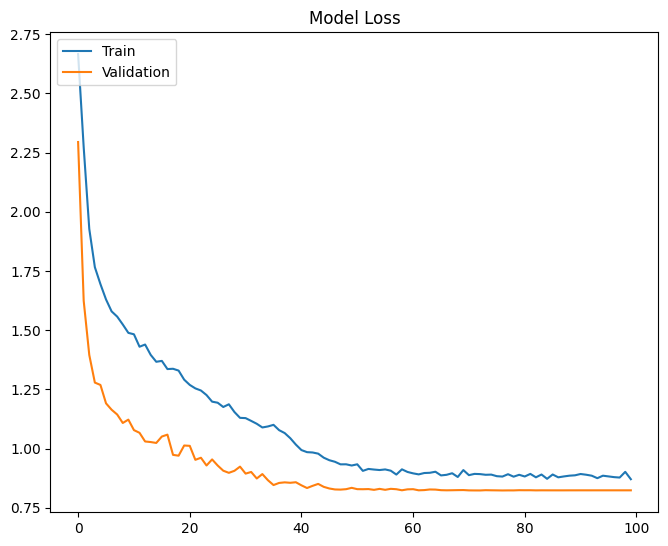

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel=('Epoch')
plt.ylabel=('Loss')
plt.legend(['Train','Validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0,hspace=0.25,wspace=0.35)

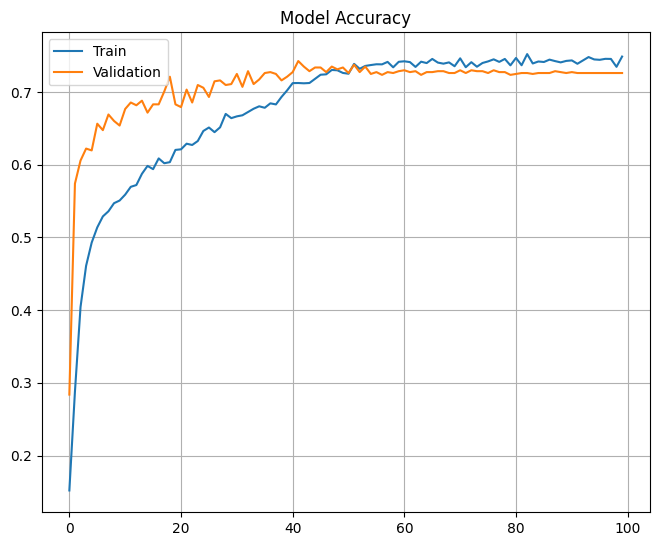

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel=('Epoch')
plt.ylabel=('Accuracy')
plt.legend(['Train','Validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0,hspace=0.25,wspace=0.35)
plt.grid()

In [39]:
pred=model.predict(X_test)

2024-07-31 08:57:11.637432: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2175: 3.31527, expected 2.86333
2024-07-31 08:57:11.637514: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8832: 3.04387, expected 2.59193
2024-07-31 08:57:11.637524: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8960: 3.285, expected 2.83305
2024-07-31 08:57:11.637535: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9600: 3.16471, expected 2.71277
2024-07-31 08:57:11.637553: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12032: 3.08921, expected 2.63726
2024-07-31 08:57:11.637575: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15360: 3.30205, expected 2.8501
2024-07-31 08:57:11.637650: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32768: 4.65504, expected 3.81534
2024-07-31 08:57:11.637658: E exte

44/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

W0000 00:00:1722416233.202677      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2024-07-31 08:57:13.629135: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.73934, expected 3.23023
2024-07-31 08:57:13.629183: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 3.62197, expected 3.11286
2024-07-31 08:57:13.629192: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 3.87954, expected 3.37043
2024-07-31 08:57:13.629200: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 3.47842, expected 2.96931
2024-07-31 08:57:13.629208: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 3.88297, expected 3.37386
2024-07-31 08:57:13.629216: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32: 3.63122, expected 3.12211
2024-07-31 08:57:13.629224: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 43: 3.30186, expected 2.79275
2024-07-31 08:57:13.629232: E external/local_xla/xla/

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


In [40]:
i=0
Pred_l=[]
while(i<len(pred)):
    Pred_l.append(int(np.argmax(pred[i])))
    i=i+1

In [41]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [42]:
report=classification_report(y_test,Pred_l)
print(report)

              precision    recall  f1-score   support

           0       0.40      0.34      0.36       148
           1       0.68      0.76      0.72       169
           2       0.95      0.87      0.91       234
           3       0.61      0.79      0.69       165
           4       0.92      0.89      0.90       178
           5       0.49      0.60      0.54       151
           6       0.82      0.89      0.86       188
           7       0.89      0.86      0.87       152
           8       0.95      0.86      0.90       165
           9       0.88      0.87      0.88       220
          10       0.61      0.39      0.48       145
          11       0.34      0.39      0.37       123
          12       0.77      0.72      0.74       147
          13       0.95      0.96      0.95       184

    accuracy                           0.75      2369
   macro avg       0.73      0.73      0.73      2369
weighted avg       0.76      0.75      0.75      2369



In [43]:
results=confusion_matrix(y_test,Pred_l)
print(results)

[[ 50   1   0  20   0   6   0   0   0   0   1  64   5   1]
 [  2 128   1   7   4  25   0   0   0   0   1   0   1   0]
 [  0  17 203   1   4   7   1   0   0   0   0   1   0   0]
 [  6   6   1 131   0   4   6   2   0   0   1   5   1   2]
 [  1   5   1   4 158   4   1   0   0   0   0   0   0   4]
 [  6  25   2  12   2  90   0   0   0   0   9   4   1   0]
 [  0   0   0   6   0   0 168   0   0  12   0   0   1   1]
 [  1   0   0   0   0   0   3 130   6  12   0   0   0   0]
 [  0   0   3   6   0   3   0  10 142   1   0   0   0   0]
 [  0   1   0   2   0   0  22   4   0 191   0   0   0   0]
 [  6   2   1  10   1  36   0   0   1   0  57   9  21   1]
 [ 51   1   0  13   0   6   0   0   0   0   1  48   2   1]
 [  2   1   2   2   0   2   0   0   1   0  22   9 106   0]
 [  1   0   0   0   3   0   3   0   0   0   1   0   0 176]]


<Axes: >

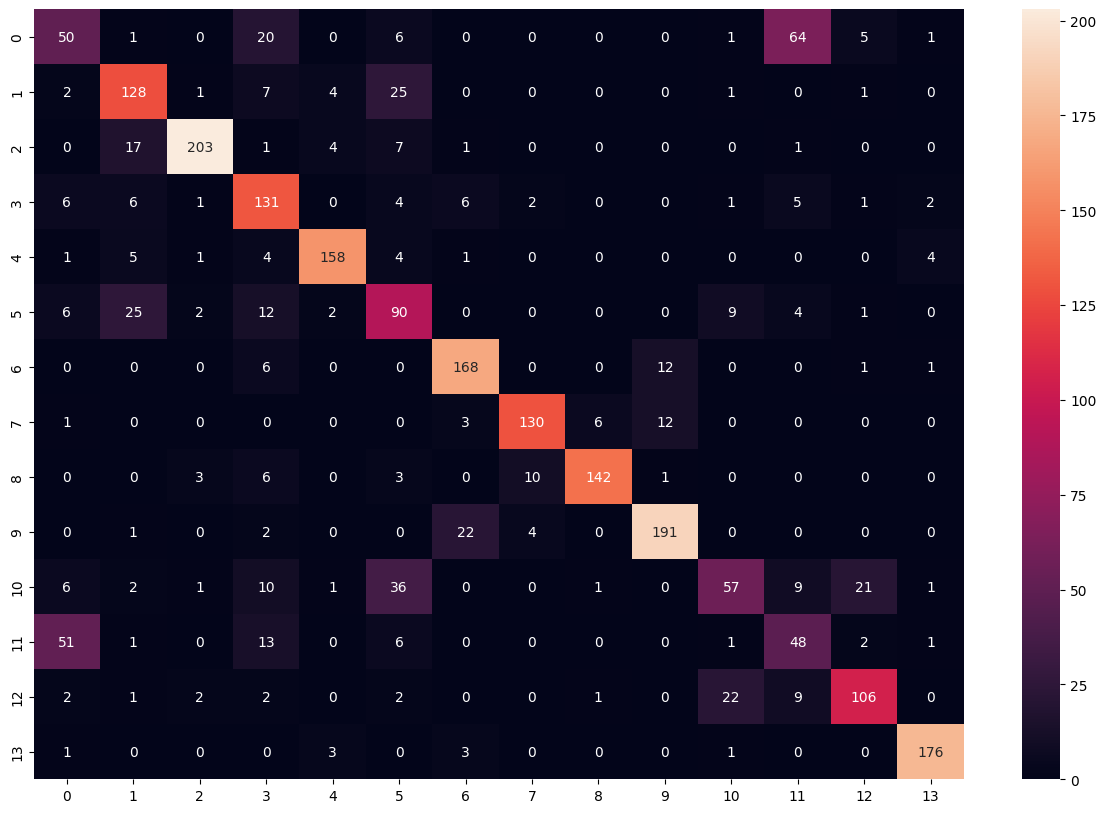

In [44]:
import seaborn as sns
plt.figure(figsize=(15,10))
sns.heatmap(results,annot=True, fmt=".0f")